In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [2]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6b088280c4d29fa0ef856b689da9fc5694c05a5dfbc4f5ee8183da8fa48265c6
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
from transformers import PreTrainedModel
import torch
from rouge_score import rouge_scorer
from torch import nn
import json
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, PreTrainedModel
from torch import nn
from sklearn.utils import resample
from evaluate import load
import os
# For PEFT and LoRA
from peft import LoraConfig, TaskType, get_peft_model
rouge = load("rouge")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/essay-scoring/balanced_essay_data_2.csv


In [4]:
class FlanT5Generator(PreTrainedModel):
    def __init__(self, model_name="google/flan-t5-base"):
        config = T5Config.from_pretrained(model_name)
        super().__init__(config)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, labels=None, **kwargs):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            labels=labels,
            **kwargs
        )

    def generate(self, *args, **kwargs):
        return self.model.generate(*args, **kwargs)

    def prepare_inputs_for_generation(self, *args, **kwargs):
        return self.model.prepare_inputs_for_generation(*args, **kwargs)

class EssayDataset(Dataset):
    def __init__(self, texts, feedbacks, tokenizer, max_length=512):

        self.texts = texts
        self.feedbacks = feedbacks
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        feedback_dict = self.feedbacks[idx]  
        
       
        feedback = (
            f"Overall Evaluation: {feedback_dict['overall_evaluation']}\n"
            f"Strengths: {feedback_dict['strengths']}\n"
            f"Areas for Improvement: {feedback_dict['areas_for_improvement']}"
        )
        
        
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        targets = self.tokenizer(
            feedback,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": targets["input_ids"].squeeze(0)
        }




def train_epoch(model, dataloader, optimizer, device, tokenizer):
    model.train()
    all_preds = []
    all_targets = []

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

       
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

      
        predicted_ids = torch.argmax(logits, dim=-1)
        predicted_texts = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
        target_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

        
        rouge_score = rouge.compute(predictions=predicted_texts, references=target_texts)

       
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        all_preds.extend(predicted_texts)
        all_targets.extend(target_texts)

        progress_bar.set_postfix(loss=loss.item())

    
    rouge_results = rouge.compute(predictions=all_preds, references=all_targets)

    metrics = {
        "loss": loss.item(),
        "rouge1": rouge_results["rouge1"],
        "rouge2": rouge_results["rouge2"],
        "rougeL": rouge_results["rougeL"]
    }

    return metrics


def evaluate(model, dataloader, device, tokenizer):
    model.eval()
    predictions_list = []
    targets_list = []
    
    
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, 
                          attention_mask=attention_mask, 
                          labels=labels)
            
            predicted_ids = torch.argmax(outputs.logits, dim=-1)
            predicted_texts = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
            target_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

           
            for pred, target in zip(predicted_texts, target_texts):
                scores = rouge.score(target, pred)
                rouge_scores.append({
                    'rouge1': scores['rouge1'].fmeasure,
                    'rouge2': scores['rouge2'].fmeasure,
                    'rougeL': scores['rougeL'].fmeasure
                })

            predictions_list.extend(predicted_texts)
            targets_list.extend(target_texts)

   
    avg_rouge = {
        'rouge1': np.mean([s['rouge1'] for s in rouge_scores]),
        'rouge2': np.mean([s['rouge2'] for s in rouge_scores]),
        'rougeL': np.mean([s['rougeL'] for s in rouge_scores])
    }

    return avg_rouge, predictions_list, targets_list



def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)              
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = re.sub(r"[^a-z0-9.,!?'\s]", ' ', text)      
    text = re.sub(r'\s+', ' ', text).strip()           
    return text


def load_dataset(scale_scores=True, min_len=30):
    df = pd.read_csv("/kaggle/input/essay-scoring/balanced_essay_data_2.csv")

    df = df.dropna(subset=['essay', 'score'])
    df = df.drop_duplicates(subset='essay').reset_index(drop=True)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[df['essay'].str.strip() != ""]
    df['essay'] = df['essay'].apply(clean_text)
    df = df[df['essay'].str.split().apply(len) >= min_len]

    if scale_scores:
        df['score'] = np.floor(df['score'] * 10) / 10

    target_size = len(df[df['score'] == 1.0])
    grouped = [g for _, g in df.groupby('score')]

    balanced = pd.concat([
        resample(g,
                 replace=(len(g) < target_size),
                 n_samples=target_size,
                 random_state=42)
        for g in grouped
    ])

    balanced = generate_feedback(balanced)

    balanced = balanced[["essay", "feedback"]]

    return balanced.reset_index(drop=True)

def generate_feedback(df):
    feedback_list = []

    for score in df["score"]:
        if score >= 0.7:
            overall = "This essay is strong overall, showing excellent organization, development of ideas, and clarity in expression."
            strengths = "Ideas are well-structured, arguments are persuasive, and language use is mostly mature and accurate."
            improvements = "Polish minor grammar issues and ensure transitions are smooth to reach perfection."

        elif score >= 0.5:
            overall = "This essay is fairly effective, with generally clear ideas and good effort in structure."
            strengths = "The essay presents organized thoughts and some persuasive arguments."
            improvements = "Work on refining grammar and strengthening transitions between points."

        elif score >= 0.3:
            overall = "This essay has potential but needs improvement in structure, clarity, and development."
            strengths = "There are some clear ideas, and an effort to support them is noticeable."
            improvements = "Improve sentence flow, avoid repetition, and develop arguments more fully."

        else:
            overall = "This essay is underdeveloped and difficult to follow, with significant issues in structure and language."
            strengths = "The attempt to engage with the topic is visible."
            improvements = "Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas."

        feedback_list.append({
            "overall_evaluation": overall,
            "strengths": strengths,
            "areas_for_improvement": improvements
        })

    df["feedback"] = feedback_list
    return df

def save_structured_output(texts, predictions, targets, output_prefix="structured_output"):

    structured_data = []

    for i in range(len(texts)):
        item = {
            "essay_id": i,
            "essay_text": texts[i],
            "generated_feedback": predictions[i],  
            "actual_feedback": targets[i]  
        }
        structured_data.append(item)

    
    with open(f"{output_prefix}.json", "w", encoding="utf-8") as f_json:
        json.dump(structured_data, f_json, indent=4)

    print(f"Structured output saved to {output_prefix}.json")


In [5]:
df = load_dataset()

In [6]:
df

,essay,feedback
0,the planet venus is kinda like an extra star i...,{'overall_evaluation': 'This essay is underdev...
1,have you ever thought that maybe a president d...,{'overall_evaluation': 'This essay is underdev...
2,"in the passage , the author is explaining how ...",{'overall_evaluation': 'This essay is underdev...
3,nasa has been working with space for a very lo...,{'overall_evaluation': 'This essay is underdev...
4,i think we should keep the electoral college b...,{'overall_evaluation': 'This essay is underdev...
...,...,...
37291,i believe schools have made the right decision...,{'overall_evaluation': 'This essay is strong o...
37292,"when it comes to education, there are various ...",{'overall_evaluation': 'This essay is strong o...
37293,"as technology advances with time , modern stud...",{'overall_evaluation': 'This essay is strong o...
37294,"for many years , summer projects have been giv...",{'overall_evaluation': 'This essay is strong o...


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [8]:

lora_base_model = FlanT5Generator().to(device)
base_model =  FlanT5Generator().to(device)


peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=[
        "q",  
        "v", 
        "k", 

    ],
    modules_to_save=["lm_head"]
)

model = get_peft_model(lora_base_model, peft_config).to(device)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

FlanT5Generator has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package 

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:

train_texts, test_texts, train_feedbacks, test_feedbacks = train_test_split(
    df["essay"], df["feedback"],  
    test_size=0.2, random_state=42
)


train_dataset = EssayDataset(train_texts.reset_index(drop=True), train_feedbacks.reset_index(drop=True), tokenizer)
test_dataset = EssayDataset(test_texts.reset_index(drop=True), test_feedbacks.reset_index(drop=True), tokenizer)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

In [13]:
if __name__ == "__main__":
    b_metrics, b_predictions, b_targets = evaluate(base_model, test_loader, device, tokenizer)
    print("Before Training Metrics:", b_metrics)
    for epoch in range(1):
        print(f"Epoch: {epoch+1}")
        train_metrics = train_epoch(model, train_loader, optimizer, device, tokenizer)
        print("Training Metrics:", train_metrics)
        a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device, tokenizer)
        print("After Training Metrics:", a_metrics)

Before Training Metrics: {'rouge1': 0.11949522376871223, 'rouge2': 0.0070580395196649945, 'rougeL': 0.07960911020536737}
Epoch: 1


Training Metrics: {'loss': 0.024010876193642616, 'rouge1': 0.5884157348136494, 'rouge2': 0.3705988010754764, 'rougeL': 0.5362814376838014}


After Training Metrics: {'rouge1': 0.9839908867834269, 'rouge2': 0.9672073639437168, 'rougeL': 0.9839908867834269}


In [15]:
from peft import PeftModel

model.save_pretrained("lora_flan_adapter")


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


In [17]:
import matplotlib.pyplot as plt


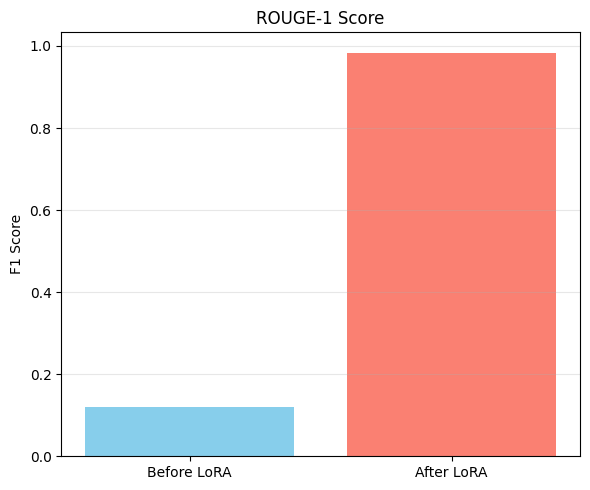

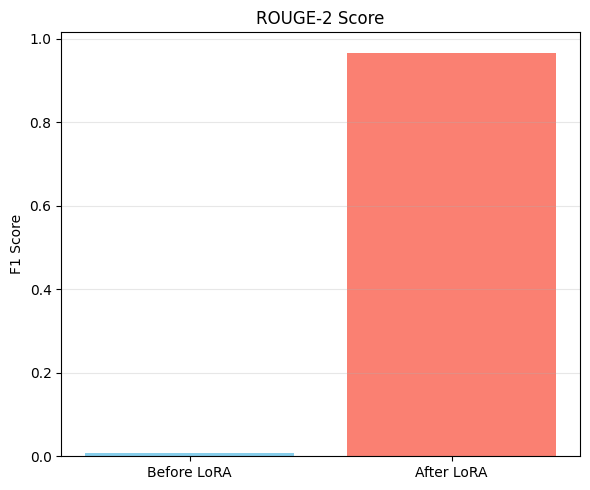

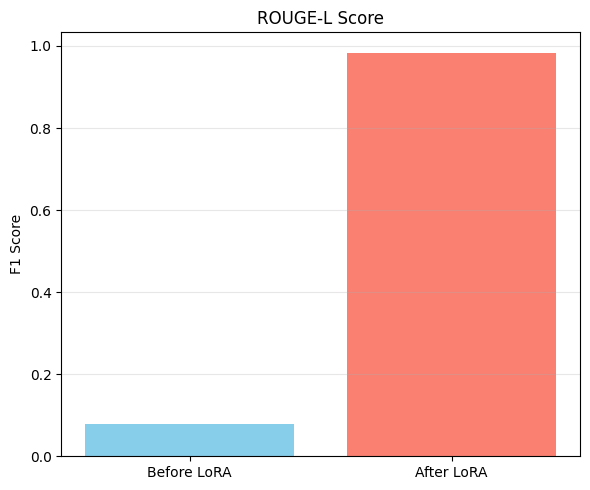

In [26]:

rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
b_values = [b_metrics[m] for m in rouge_metrics]
a_values = [a_metrics[m] for m in rouge_metrics]


for i, metric in enumerate(rouge_metrics):
    plt.figure(figsize=(6, 5))  
    plt.bar([0, 1], [b_values[i], a_values[i]], color=['skyblue', 'salmon'])
    plt.xticks([0, 1], ['Before LoRA', 'After LoRA'])
    plt.ylabel('F1 Score')
    plt.title(f'ROUGE-{metric[-1]} Score')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [19]:
save_structured_output(test_texts.tolist(), a_predictions, a_targets, output_prefix="model_output")

Structured output saved to model_output.json


In [ ]:
def predict_feedback(model, tokenizer, text, device, max_length=512):
   
    model.eval()
    model.to(device)
    
   
    text_cleaned = clean_text(text)

    
    inputs = tokenizer(
        text_cleaned,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True
    ).to(device)

  
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
            temperature=0.7
        )

    
    full_feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    
    result = {"full_feedback": full_feedback}
    
    
    sections = {
        "overall_evaluation": "Overall Evaluation:",
        "strengths": "Strengths:",
        "areas_for_improvement": "Areas for Improvement:"
    }
    
    for key, marker in sections.items():
        start_idx = full_feedback.find(marker)
        if start_idx >= 0:
            start_idx += len(marker)
            end_idx = full_feedback.find("\n\n", start_idx)
            result[key] = full_feedback[start_idx:end_idx].strip() if end_idx > 0 else full_feedback[start_idx:].strip()
        else:
            result[key] = "Not found in feedback"
    
    return result




In [23]:
# Example usage
essay = """
Standardized testing has long been used to measure student achievement, but it fails to capture the full scope of a student's abilities. 
While some argue that tests provide objective data, they often reduce learning to memorization rather than critical thinking. 
A single test cannot reflect creativity, collaboration, or problem-solving skills—all essential in real-world settings. 
Moreover, standardized exams disproportionately disadvantage students from under-resourced backgrounds, reinforcing existing inequalities. 
Instead of focusing on test scores, schools should adopt a more holistic approach to assessment. 
Project-based learning, portfolios, and teacher evaluations offer more comprehensive insights into student growth. 
Countries like Finland, known for top-performing education systems, have minimized standardized testing and instead emphasize trust in teachers and student-centered learning. 
Their success demonstrates that meaningful education doesn't need to be driven by exams. 
In conclusion, standardized tests should not define academic success. 
Schools must evolve to measure what truly matters: the ability to think, create, and apply knowledge in diverse contexts.
"""

result = predict_feedback(model, tokenizer, essay, device)
print("\nFull Generated Feedback:\n", result['full_feedback'])
print("\nParsed Components:")
print("-" * 50)
print("Overall Evaluation:", result['overall_evaluation'])
print("\nStrengths:", result['strengths'])
print("\nAreas for Improvement:", result['areas_for_improvement'])

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Full Generated Feedback:
 Overall Evaluation: This essay is underdeveloped and difficult to follow, with significant issues in structure and language. Strengths: The attempt to engage with the topic is visible. Areas for Improvement: Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas.

Parsed Components:
--------------------------------------------------
Overall Evaluation: This essay is underdeveloped and difficult to follow, with significant issues in structure and language. Strengths: The attempt to engage with the topic is visible. Areas for Improvement: Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas.

Strengths: The attempt to engage with the topic is visible. Areas for Improvement: Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas.

Areas for Improvement: Focus on organizing your thoughts clearly, using proper grammar, and 